## R(t)

Busco reproducir numéricamente algunas cuentas del paper de Bunkin 1993. El objetivo es conocer cómo se comporta la presión y el radio en función del tiempo tanto para la evolución de un solo bubston como la evolución de la burbuja formada por un conjunto de bubstons.



Calculo el radio en función del tiempo usando la ecuación 2.2.1.1 de la tesis de Gabriela  
1. A través del cambio de variables R = R, v_R = R', transformo la ecuación diferencial de orden 2 en dos ecuaciones diferenciales de orden 1
2. Me armo el sistema dy/dt = f(y,t) donde y = (R, v_R) y resuelvo la ecuación numéricamente
(El desarrollo de las ecuaciones está en el cuadernillo)

Comentarios:  
* La dependencia de la presión de la burbuja p_B está dada por la presión eléctrica p_e del paper de Bunkin
* La dependencia de la masa m(t) se asume conocida pero realmente habría que estimarla usando el problema de reacciones + condensación o, mejor dicho, resolviendo todo autoconsistentemente.
* Las fórmulas del paper están en el sistema CGS, así que expreso todo en esas unidades

DUDAS:
* Estoy considerando rho_L_inf = rho_L_i, está bien?
* Estoy tomando x_max = 6 (aproximación del paper antes de la ec. (18)), está bien?
* rho_Bunkin = rho_L_inf  o rho_L_i ? Estoy considerando a priori lo primero, está bien?
* u0 (mu) da igual que a lo que da la ec. 19a (19b)? Sí, da lo mismo. u0 da ligeramente distinto pero creo que puede deberse a que estoy tomando una densidad distinta.
* Estoy asumiendo que las ecuaciones de Bunkin están en el sistema MKS y por lo tanto los parámetros del problema están en MKS
* Verificar si T_e = Delta/3 siempre o cambia durante la evolución
* R0 = 1e-6 
* v_R0 = 0? condición inicial
* En la solución numérica se asumió que el problema no es stiff
* a_i = 2e-5 para nuestro problema? radio del electrolito
* l = 2*a_i #aproximación hecha en el Bunkin

In [1]:
#Importo librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from math import pi

### Parámetros del problema general
en sistema de unidades CGS:
https://es.wikipedia.org/wiki/Sistema_Cegesimal_de_Unidades

In [2]:
#En CGS:
#Parámetros de la ecuación diferencial
p_inf = 0.925 #Presión ambiente en el infinito en [atm]. Son 0.925 atm correspondientes a Bariloche. 
p_inf = p_inf*(101325)*(1/0.1) #en [baria] (CGS). Conversión: (atm)(101325 Pa/atm)(baria/ 0.1 Pa)
c_L = 1415.1 #velocidad del sonido del líquido en [m/s] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela.
c_L = c_L*100 #en [cm/s] (CGS). Conversión (m/s)*(100 cm/m)
rho_L_i = 1101.8 #densidad del líquido en la superficie de la burbuja en [kg/m3] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela. 
rho_L_i = rho_L_i*(1/100)**3*(1000) #en [g/cm3] (CGS). Conversión (kg/m3)*(1m/100cm)^3*(1000g/1Kg)
rho_L_inf = rho_L_i #densidad del líquido en el infinito. A priori considero rho_L_inf = rho_L_i

#Parámetros de la presión eléctrica p_e

#En CGS:
#Condiciones iniciales de la ecuación diferencial
Delta = 6 #Energía mecánica para arrancar un electrón de la pared en [eV]
T_e = Delta/3 #Temperatura de los electrones dentro de la burbuja en [eV]. Conversión: (ev)*()
T_e = T_e*(1.602176565e-19)*(1/1e-7) #en [erg] (CGS). Conversión (1ev)(1.602176565e-19J/1ev)*(1erg/1e-7 J)

x_max = 6 #Esto es una aproximación considerada en el paper antes de la ec. (18)
q_e = -1.602176634e-19 #carga del electrón en [Coulomb]
q_e = q_e*(1/3.336641e-10) #en [Fr] (CGS). Conversión (C)*(Fr/3.336641e-10 C)

R0 = 1e-6 #Radio inicial de un bubston en [cm]. Este valor lo saqué del supuesto inicial del Bunkin

rho_Bunkin = rho_L_inf #densidad del líquido


### Desarrollo de la avalancha de electrones

Durante este breve proceso (de alrededor de 6e-11 s) el nro de electrones alcanza su valor máximo. Verifico el comportamiento de x y expreso la presión eléctrica

In [6]:
#Verifico la aproximación x \approx 6 antes de (18)

def T_e_bubs(R):
    #Calcula la temperatura de los electrones en función del radio
    return T_e

def n_e_max_mean(T_e,R0):
    #Calcula la densidad media máxima a partir de la expresión (11)
    return (16/3)*T_e**2/(pi*q_e**4*R0)

def Ne_max(T_e,R0):
    #Calcula el nro máximo de electrones en un bubston a partir de la expresión siguiente a la (11)
    return n_e_max_mean(T_e, R0)*4/3*pi*R0**3

from scipy.optimize import fsolve

#Defino la expresión (9) cuya solución es x

def x(T_e, R0, Ne):

    def ec_9(x):
        #Expresión (9) del paper de Bunkin tal que está igualada a cero
        return np.log(3*Ne*q_e**2/(T_e*R0)) + np.log(1/(1-1/x)) - x

    return fsolve(ec_9, 2)[0]

x(T_e, R0, Ne_max(T_e, R0))

#La solución es aproximadamente 6

5.878449643520933

In [ ]:


# def p_e(T_e, R0, Ne):
#     #Presión de electrones a partir de la expresión (17) del paper de Bunkin
#     x = x(T_e, R0, Ne)

#     ne_mean = 
#     T_e

#     return 0

### Coalescencia de los bubston (evolución temporal de un único bubston)


Durante este proceso el bubston crece en tamaño hasta tocar a otros bubstons. Este proceso se enmarca en el régimen llamado "régimen de autoconsistencia" en el cual la temperatura depende del Radio y, por lo tanto, tengo que calcular x radio a radio

In [21]:
#Bajo este régimen

# def T_e_bubs(R):
#     #Calcula la temperatura de los electrones en función del radio
#     return T_e

def n_e_max_mean(T_e,q_e, R0):
    #Calcula la densidad media máxima a partir de la expresión (11)
    return (16/3)*T_e**2/(pi*q_e**4*R0)

def u0(T_e, q_e, R0):
    #Calculo u0 a partir de expresión (19a) del paper de Bunkin
    return np.sqrt( (2*x_max/9)*n_e_max_mean(T_e, q_e, R0)*T_e/rho_Bunkin )

def mu(T_e, q_e, R0):
    #Calculo mu a partir de expresión (19b) del paper de Bunkin
    return (8/(3*x_max))*((x_max-1)/x_max)**2*(T_e*R0/q_e**2)

In [5]:
#Verifico si obtengo los mismos valores
print("n_e_max_mean = ", n_e_max_mean)
print("u0 = ", u0)
print("mu = ", mu)

n_e_max_mean =  <function n_e_max_mean at 0x0000020D9C4F2F70>
u0 =  <function u0 at 0x0000020DBB87E550>
mu =  <function mu at 0x0000020DBD348670>


### Funciones de presión y masa

In [22]:
#Defino la función de masa y sus derivadas

#Asumo que a t = 0 hay N_H2O_0 partículas de agua vapor (es indistinto que sea vapor o líquido)
Na = 6.02214076e23 #Nro de Avogadro
m_H2O = 18/Na #Masa de una molécula de agua en [g]
N_H2O_0 = 1e3 #Nro de partículas de agua iniciales
m0 = N_H2O_0*m_H2O #Masa inicial

def m(t):
    # Dependencia de la masa en [g] en función del tiempo. 
    # A priori se asume que es conocida e igual a parábola de coeficientes alpha y m0 arbitrarios
    # Realmente habría que estimarla usando el problema reacciones + condensación o, mejor dicho, resolviendo todo autoconsistentemente
    #Asumo que a t=0 la masa es m0 y a t=100 mu s la masa es 10*m0:
    alpha = 9*m0/(100e-6)**2
    return alpha*t**2 + m0

def mp(t):
    #Derivada de la masa en función del tiempo
    alpha = 9*m0/(100e-6)**2
    return 2*alpha*t

def mpp(t):
    #Segunda derivada de la masa en función del tiempo
    alpha = 9*m0/(100e-6)**2
    return 2*alpha

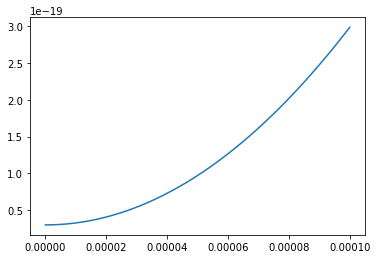

In [23]:
#Grafico m(t)
t = np.linspace(0, 100e-6, 1000)
plt.plot(t, m(t));

In [24]:
#Presión eléctrica del paper de Bunkin
def p_e(R, T_e, q_e, R0):
    #Presión eléctrica en [baria] (CGS) del paper de Bunkin ec. (24)
    #R: radio del bubston en cm
    return rho_Bunkin*u0(T_e, q_e, R0)**2*(1 + 2*mu(T_e, q_e, R0))*(R0/R)**4

def dpdt_e(R, v_R, T_e, q_e, R0):
    #Derivada de la presión eléctrica respecto a t en [baria/s] del paper de Bunkin
    #R: radio del bubston en cm
    dpdR_e = rho_Bunkin*u0(T_e, q_e, R0)**2*(1 + 2*mu(T_e, q_e, R0))*(-4/R0)*(R0/R)**5 #Derivada respecto al radio
    dpdt_e = dpdR_e*v_R #Derivada respecto al tiempo
    return dpdt_e

In [25]:
#Presión de las partículas de gas asumiendo comportamiento ideal (MODELO FENOMENOLOGICO)

def V(R):
    #Volumen de una esfera de radio R
    return (4/3)*pi*R**3

def dVdR(R):
    #Derivada del volumen de una esfera de radio R respecto a su radio
    return 4*pi*R**2

def p_GI(R):
    #Presión de las partículas de gas asumiendo comportamiento ideal en [baria] (CGS). Asumo que la temperatura corresponde a la del líquido en el infinito
    
    Tinf=35+273.15 #Esto lo usamos para calcular rho_L_i

    m_H20 = 18/Na #Masa de una partícula de H20 en [g]. Está en g porque m(R) también lo está
    N = m(R)/m_H20 #Nro de partículas

    K_B = 1.380649e-23 #cte de Boltzmann en [J/K]
    K_B = K_B/1e-7 #en [ergio/K]. Conversión: (J/K)*(1erg/10−7J)

    P = N * K_B * Tinf / V(R)
    return 0
    return P

def dpdt_GI(R, v_R):
    #Derivada de la presión del gas respecto al tiempo en [baria/s] (CGS)
    dpdR_GI = -p_GI(R)/V(R)*dVdR(R) #Derivada respecto al radio
    dpdt_GI = dpdR_GI*v_R #Derivada respecto al tiempo
    return 0
    return dpdt_GI


In [26]:
#Defino funciones de presión

def p_B(R,T_e, q_e, R0):
    #Presión de la burbuja. Se considera que es igual a la presión de eléctrica p_e del paper de Bunkin más una presión de GI. El objetivo de esta presión es verificar si tienen o no efecto las moléculas dentro del bubston.
    return p_e(R,T_e, q_e, R0) + p_GI(R)

def dpBdt(R, v_R,T_e, q_e, R0):
    #Derivada de la presión de la burbuja
    return dpdt_e(R, v_R,T_e, q_e, R0) + dpdt_GI(R, v_R)


### Sistema de ecuaciones diferenciales

In [27]:
#Defino el sistema de ecuaciones de primer orden

def dydt(t,y):
    #Sistema de ecuaciones de primer orden para la evolución del radio en función del tiempo. Entiéndase y = (R, Rp) = (R, v_R)
    v_R = y[1]
    R = y[0]

    #Defino las ctes del sistema
    T_e_ = T_e
    q_e_ = q_e
    R0_ = R0

    #Defino los términos de la ecuación diferencial de R(t). Genéricamente coloco como inputs mp, mpp, R y v_R aunque no haya tal dependencia
    #Los términos se encuentran definidos en mi cuadernillo

    #Expreso dydt_0 = dR/dt = v_R
    dydt_0 = v_R

    #Para dydt_2 = d(v_R/dt) = d2(R)/dt2 hay 2 posibilidades
    #(1) usar la ecuación diferencial de la tesis de Gabriela
    #(2) usar la ecuación diferencial del paper de Bunkin que es una aproximación de la ecuación diferencial de Gabriela


    #(1)
    # term1 = -(3/2)*v_R**2*(1 - v_R/(3*c_L) + 2*mp(t)/(3*c_L*rho_L_i))
    # term2 = (1/rho_L_i)*(1 + v_R/c_L)*(p_B(R,T_e_, q_e_, R0_) - p_inf)
    # term3 = (mpp(t)*R/rho_L_i)*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))
    # term4 = (mp(t)/rho_L_i)*(v_R - mp(t)/(2*rho_L_i) + mp(t)*v_R/(2*c_L*rho_L_i))
    # term5 = (R/c_L*rho_L_inf)*dpBdt(R, v_R,T_e_, q_e_, R0_)
    # dydt_1 = (1/(R*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))     ))*(term1 + term2 + term3 + term4 + term5)

    #(2)
    dydt_1 = (p_B(R,T_e_, q_e_, R0_)/(rho_L_i) - 3/2*v_R**2)/R

    
    return [dydt_0, dydt_1]


### Solución numérica

In [28]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = 70e-9 #70 ns
y_ini = [R0, 0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol)
#asumo que el problema no es stiff


In [29]:
#Imprimo propiedades de la solución
print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1886
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 8.21086416e-23, 9.03195058e-22, 9.11405922e-21,
       8.95575020e-20, 6.93558594e-19, 3.23710135e-18, 1.23359087e-17,
       3.91533481e-17, 1.36267984e-16, 3.63704180e-16, 1.05955518e-15,
       2.89676787e-15, 9.37484101e-15, 3.91616684e-14, 2.57956183e-13,
       6.79308586e-13, 1.08600943e-12, 1.48694222e-12, 1.89609638e-12,
       2.32233843e-12, 2.77587896e-12, 3.27296176e-12, 3.84950512e-12,
       4.50657597e-12, 5.05147823e-12, 5.48505516e-12, 5.91863209e-12,
       6.41408780e-12, 6.99311966e-12, 7.65001238e-12, 8.40742253e-12,
       9.32453008e-12, 1.06752740e-11, 1.17730574e-11, 1.28708409e-11,
       1.39683304e-11, 1.50930637e-11, 1.62612111e-11, 1.74841972e-11,
       1.87715457e-11, 2.01318387e-11, 2.15729855e-11, 2.31019791e-11,
       2.47239042e-11, 2.64392348e-11, 

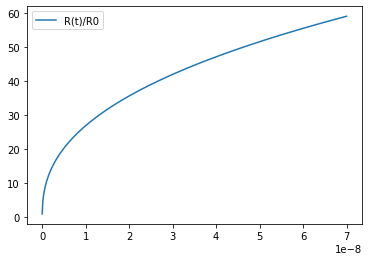

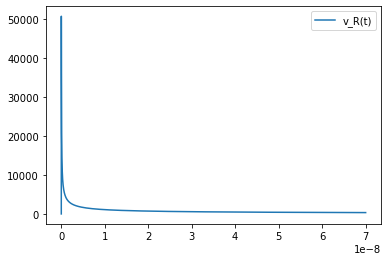

C:\Users\lupam\AppData\Local\Temp\ipykernel_26664\3442091702.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return rho_Bunkin*u0(T_e, q_e, R0)**2*(1 + 2*mu(T_e, q_e, R0))*(R0/R)**4
C:\Users\lupam\AppData\Local\Temp\ipykernel_26664\2798353852.py:22: RuntimeWarning: divide by zero encountered in true_divide
  P = N * K_B * Tinf / V(R)


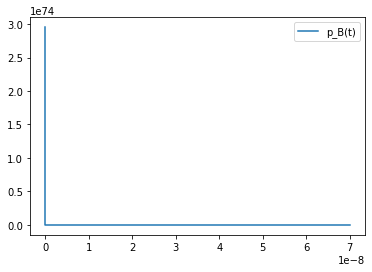

In [30]:
#Grafico
plt.plot(sol.t, sol.y[0]/R0, label = "R(t)/R0")
plt.legend()
plt.show()

plt.plot(sol.t, sol.y[1], label = "v_R(t)")
plt.legend()
plt.show()

plt.plot(sol.t, p_B(sol.t,T_e, q_e, R0), label = "p_B(t)")
plt.legend()
plt.show()


### Verificación

Según el paper de Bunkin, a t = t_coal debe ocurrir que R = R1, ambos parámetros bien definidos
Supongamos por lo pronto que m = 0 para todo tiempo, asumiendo que la masa de los electrones entrantes, que son los responsables de la expansión inicial, es despreciable

In [31]:
a_i = 2e-5 #radio de Debye de un ion electrolito en un líquido. En este caso el agua (valor sacado del Bunkin) en [cm]
t_coal = ( 2/5*(R0/u0(T_e, q_e, R0)) )/np.sqrt(2*(1 + 2*mu(T_e, q_e, R0)))*(a_i/R0)**(5/2) #tiempo de coalescencia en [s] (creo)
l = 2*a_i #aproximación hecha en el Bunkin*
R1 = l/2 #radio del bubston necesario para que las burbujas se toquen

print("tiempo de coalescencia (t_coal): ", t_coal)
print("radio relativo teórico del bubston en t = t_coal (R1/R0): ", R1/R0)

tiempo de coalescencia (t_coal):  4.584739171374519e-09
radio relativo teórico del bubston en t = t_coal (R1/R0):  20.000000000000004


In [33]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = t_coal
y_ini = [R0, 0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol)
#asumo que el problema no es stiff

print("radio numérico del bubston en t = t_coal (R1): ", sol.y[0][-1]/R0)
print("velocidad radial del bubston en t = t_coal (R1): ", sol.y[1][-1])

radio numérico del bubston en t = t_coal (R1):  19.63521432788798
velocidad radial del bubston en t = t_coal (R1):  1747.4962431181277


#### Consideraciones
Encontré que el resultado es independiente de si m(t) = 0 o no. Esto tiene sentido porque m(t) hace referencia a los iones/moléculas de dentro y según el paper de Bunkin no tienen efecto inicialmente tales partículas. Habría que verificar esto formalmente poniendo una presión debido a tales partículas, por ejemplo debido a un GI.

A continuación se detallan el radio del bubston en t = t_coal(R1) considerando o no la masa y la presión de las partículas:
* m = 0, p_GI = 0: 16.028292831866146
* m!= 0 (N_H2O_0 = 1e9), p_GI = 0: 16.028292831866146
* m!= 0 (N_H2O_0 = 1e9), p_GI!= 0: 81.30913083691735 
CAMBIA CONSIDERABLEMENTE! Quizás el problema está en la cantidad de partículas consideradas. Gustavo me había dicho que el nro de partículas iniciales era despreciable respecto al nro de electrones máximos
* m!= 0 (N_H2O_0 = 1e3), p_GI!= 0: 81.30913083691735 
Tal cantidad de partículas de vapor implicaría una presión de 10 atm (p_GI(R0)*0.1*9.86923e-6
) dentro de la burbuja. Es exagerado? Sí, pero con 109 partículas tengo 107 atm....


Cambié la ecuación diferencial para la evolución del radio R(t). Ahora uso la misma expresión que Bunkin. Bajo esas condiciones obtengo que el radio R1 a t = t_coal es 19.635




Los nros siguientes los obtuve haciendo mal la cuenta. Había considerado que dpdt = dpdR y no es así
* m != 0, p_GI = 0: 19.185427198440635
* m = 0, p_GI = 0: 19.185427198440635
* m != 0, p_GI != 0:

## Formación de burbuja a partir del cluster

1. Calculamos el tiempo tal que R = R1
2. Supongo que a ese tiempo, instantáneamente se forma una burbuja con todos los bubston del cluster, de tamaño n_bubston*R1
3. Calculo la evolución de la nueva burbuja considerando tmb que hay una carga de n_bubston*e
4. Ver el efecto de considerar o no una presión de gas p_GI

Durante la evolución estoy asumiendo Te constante aunque no sea así necesariamente. También asumí que la carga "inicial" es q_e*n_bubston.

In [17]:
#Parámetros del cluster inicial
n_bubston = 1e8
Beta = 0.74 #factor que determina cuán compacto está el cluster. Este valor corresponde a the closest packing in the hard-sphere model
R_cl = a_i*(n_bubston/Beta)**(1/3) #cm
print(R_cl)

T_e_ = 0.1*(1.602176565e-19)*(1/1e-7)


0.010263277913696248


In [18]:
print(n_bubston*4/3*pi*(19.4*R0)**3)

print(4/3*pi*(R_cl)**3)

3.058396578058406e-06
4.52842184301231e-06


In [19]:
#Defino el sistema de ecuaciones diferenciales. La diferencia con el anterior es el radio inicial y la carga contenida



def dydt(t,y):
    #Sistema de ecuaciones de primer orden para la evolución del radio en función del tiempo. Entiéndase y = (R, Rp) = (R, v_R)
    v_R = y[1]
    R = y[0]

    #Defino las ctes del sistema
    
    R0_ = R1*n_bubston
    q_e_ = q_e*n_bubston #NO SÉ SI ESTO ESTÁ BIEN

    #Defino los términos de la ecuación diferencial de R(t). Genéricamente coloco como inputs mp, mpp, R y v_R aunque no haya tal dependencia
    #Los términos se encuentran definidos en mi cuadernillo

    #Expreso dydt_0 = dR/dt = v_R
    dydt_0 = v_R


    #Para dydt_2 = d(v_R/dt) = d2(R)/dt2 hay 2 posibilidades
    #(1) usar la ecuación diferencial de la tesis de Gabriela
    #(2) usar la ecuación diferencial del paper de Bunkin que es una aproximación de la ecuación diferencial de Gabriela

    #(1)
    # term1 = -(3/2)*v_R**2*(1 - v_R/(3*c_L) + 2*mp(t)/(3*c_L*rho_L_i))
    # term2 = (1/rho_L_i)*(1 + v_R/c_L)*(p_B(R,T_e_, q_e_, R0_) - p_inf)
    # term3 = (mpp(t)*R/rho_L_i)*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))
    # term4 = (mp(t)/rho_L_i)*(v_R - mp(t)/(2*rho_L_i) + mp(t)*v_R/(2*c_L*rho_L_i))
    # term5 = (R/c_L*rho_L_inf)*dpBdt(R, v_R,T_e_, q_e_, R0_)
    # dydt_1 = (1/(R*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))     ))*(term1 + term2 + term3 + term4 + term5)

    #(2)
    dydt_1 = (p_B(R,T_e_, q_e_, R0_)/(rho_L_i) - 3/2*v_R**2)/R


    return [dydt_0, dydt_1]

In [20]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = 2 #2.5e-6 #70 ns

y_ini = [R_cl, 0] #Condición inicial
rtol = 1e-8 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol)
#asumo que el problema no es stiff

print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 74
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-04, 1.1000e-03, 1.1100e-02, 1.1110e-01,
       1.1111e+00, 2.0000e+00])
 t_events: None
        y: array([[1.02632779e-02, 1.02632779e-02, 1.02632779e-02, 1.02632779e-02,
        1.02632779e-02, 1.02632779e-02, 1.02632779e-02],
       [0.00000000e+00, 1.11653382e-17, 1.22818720e-16, 1.23935254e-15,
        1.24046907e-14, 1.24058072e-13, 2.23306763e-13]])
 y_events: None


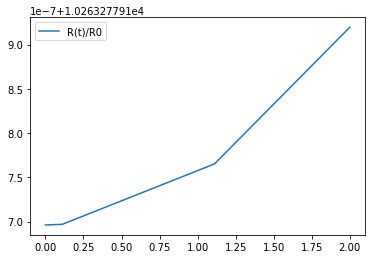

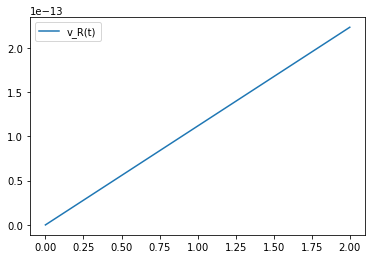

C:\Users\lupam\AppData\Local\Temp\ipykernel_14452\3442091702.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return rho_Bunkin*u0(T_e, q_e, R0)**2*(1 + 2*mu(T_e, q_e, R0))*(R0/R)**4
C:\Users\lupam\AppData\Local\Temp\ipykernel_14452\2798353852.py:22: RuntimeWarning: divide by zero encountered in true_divide
  P = N * K_B * Tinf / V(R)


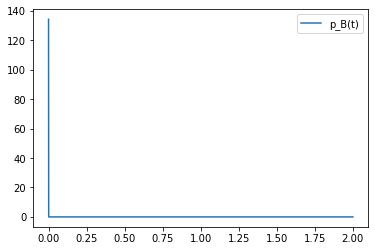

In [21]:
#Grafico
plt.plot(sol.t, sol.y[0]/R0, label = "R(t)/R0")
plt.legend()
plt.show()

plt.plot(sol.t, sol.y[1], label = "v_R(t)")
plt.legend()
plt.show()

plt.plot(sol.t, p_B(sol.t,T_e, q_e, R0), label = "p_B(t)")
plt.legend()
plt.show()


### Consideraciones
* A tal tamaño y tal cantidad de cargas la burbuja comienza a decrecer en tamaño. Esto es lo que se obtiene en el papaer?
* Con n_bubston = 10e2, a t = 2e-6 s aproximadamente se llega al mínimo. Esto ocurre independientemente de la presión producida por el GI en el interior. Luego de que la burbuja llega al cero, se produce un comportamiento oscilatorio en el que se genera una nueva burbuja y así sucesivamente.
* Con n_bubston = 10e8, el comportamiento anterior ocurre a los 2 s. Con el método numérico no puedo ejecutar el código para tiempos mayores, me da el error "Required step size is less than spacing between numbers". Según entiendo en ese punto hay una singularidad (infinito) en v_R que el solver no puede manejar
Cambié el radio del cluster. Antes estaba en 

In [22]:
70e2

7000.0

## (I) Evolución de cluster

Me olvido de las cuentas que hice antes y arranco desde cero. El objetivo es calcular la dinámica del cluster hasta que se llega a Rmax y ver si obtengo el mismo Rmax que el paper.

La presión tenida en cuenta en la ecuación diferencial de evolución de R(t) es la presión hidrostática y la de electrones, dada por la expresión (17) del Bunkin

In [3]:
#Importo librerías
import numpy as np
from math import pi
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [31]:
10**-2 - 1e-2

0.0

In [4]:
#Defino parámetros

q_e = -1.602176634e-19 #carga del electrón en [Coulomb]
q_e = q_e*(1/3.336641e-10) #en [Fr] (CGS). Conversión (C)*(Fr/3.336641e-10 C)

rho_L_i = 1101.8 #densidad del líquido en la superficie de la burbuja en [kg/m3] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela. 
rho_L_i = rho_L_i*(1/100)**3*(1000) #en [g/cm3] (CGS). Conversión (kg/m3)*(1m/100cm)^3*(1000g/1Kg)
rho_L_inf = rho_L_i #densidad del líquido en el infinito. A priori considero rho_L_inf = rho_L_i


rho_Bunkin = rho_L_inf #densidad del líquido

n_bubston = 1e8 #nro de bubston que forman un cluster

R0_1b = 1e-6 #radio inicial de un bubston en [cm]
R_cl_ini = 1e-2 #radio inicial del cluster en [cm]

N_e_max_1b = 1.4e3 #nro máximo de electrones en un bubston

T_e_ini = 2 #temperatura inicial de los electrones a R0_1b [eV]
T_e_ini = T_e_ini*(1.602176565e-19)*(1/1e-7) #en [erg] (CGS). Conversión (1ev)(1.602176565e-19J/1ev)*(1erg/1e-7 J)

p_inf = 1 #0.925 #Presión ambiente en el infinito en [atm]. Son 0.925 atm correspondientes a Bariloche. 
p_inf = p_inf*(101325)*(1/0.1) #en [baria] (CGS). Conversión: (atm)(101325 Pa/atm)(baria/ 0.1 Pa)
p0 = p_inf


sigma = 7.275e-2 #Tensión superficial en [N/m]
sigma = sigma/100/1e-5  #en [dyn/cm] (CGS). Conversión (N/m)*(1m/100cm)*(1dyn/1e-5N)

mu_vis = 0.001  #viscosidad en [Pa*s]
mu_vis = mu_vis/0.1 #en [baria*s] (CGS). Conversión: (Pa*s)(1baria/0.1Pa)
#Extra:
c_L = 1415.1 #velocidad del sonido del líquido en [m/s] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela.
c_L = c_L*100 #en [cm/s] (CGS). Conversión (m/s)*(100 cm/m)





In [12]:
(101325)*(1/0.1) / 1.013e6

1.0002467917077986

In [172]:
print(p0)

1013250.0


### Factor x

Calculo el factor x para el caso del cluster y verifico el resultado con el Bunkin

In [5]:
from scipy.optimize import fsolve
#Defino la expresión (9) cuya solución es x

def x(T_e, R0, Ne):

    def ec_9(x):
        #Expresión (9) del paper de Bunkin tal que está igualada a cero
        return np.log(3*Ne*q_e**2/(T_e*R0)) + np.log(1/(1-1/x)) - x

    return fsolve(ec_9, 2)[0]

x(T_e_ini*(R0_1b/(20*R0_1b)), R_cl_ini, N_e_max_1b*n_bubston)

#Da aproximadamente 17.97

17.97444125009335

### Presión eléctrica
Defino la presión eléctrica para el caso de un cluster formado por n_bubston.

In [6]:



def Vol(R):
    #Calcula el volumen de una esfera de radio R
    return 4/3*pi*R**3

def n_e_mean(R):
    #Densidad media de los electrones. En el modelo de Bunkin se asume que en un tiempo muy corto cada bubston alcanza el valor máximo de electrones. Luego, cuando se forma el cluster, se tienen n_bubston*N_emax_1bubston electrones
    return  N_e_max_1b*n_bubston/Vol(R)

def T_e(R):
    #Asumo que para la evolución del cluster sigue valiendo la aproximación de régimen autoconsistente

    #Está hecho para que a R = R_cl_ini obtenga 0.1 ev. De este modo, se está asumiendo que los electrones del cluster están a la misma temperatura que los electrones en la máxima expansión de cada bubston.
    return 0.1*(1.602176565e-19)*(1/1e-7)
    return 0.1*(1.602176565e-19)*(1/1e-7)*(R_cl_ini/R)
    # return T_e_ini*(R0_1b/R)

def n_e_mean_test(R):
    return n_e_mean(R)*(R_cl_ini/R)**4
    # return (16/3)*T_e(R)**2/(pi*q_e**4*R)*n_bubston

def p_electrica(n_e_mean, T_e, x, R):
    #Presión eléctrica calculada a partir de la expresión (17) del paper de Bunkin
    #n_e_mean es la densidad media de electrones
    #T_e es la temperatura de los electrones
    #x es un parámetros que depende de la densidad de electrones. Es un numerito
    #R_ini es el radio inicial de la burbuja. En el caso de la evolución del cluster es el radio inicial del cluster R_ini_cl
    return (2/3)*n_e_mean*T_e*(x/3)*(1 + pi*((x-1)/x)**2*((q_e*R)**2*n_e_mean/T_e))

from scipy.integrate import quad

def p_electrica_mean(n_e_mean, T_e, x, R):
    #Presión eléctrica promedio calculada integrando la presión eléctrica de la expresión (17) de Bunkin
    #n_e_mean es la densidad media de electrones. Depende solo del radio R de la burbuja
    #T_e es la temperatura de los electrones
    #x es un parámetros que depende de la densidad de electrones. Es un numerito
    #R es el radio inicial de la burbuja. En el caso de la evolución del cluster es el radio del cluster R_cl
    def integrando(r):
        return p_electrica(n_e_mean, T_e, x, r)*4*pi*r**2

    return (1/Vol(R))*quad(integrando,0,R)[0]


In [43]:
print(n_e_mean(R_cl_ini))
# print(n_e_mean_test(R_cl_ini))

#3.3422538049298016e+16

3.3422538049298016e+16
8.197208060707932e+21


In [5]:
p_electrica(3.4e16,0.1*(1.602176565e-19)*(1/1e-7),17.9,1e-2)/1e11

2.969049419063652

In [26]:
print(p_electrica_mean(3.4e16, T_e_ini, 17.9, R_cl_ini))
print(p_electrica(3.4e16, T_e_ini, 17.9, R_cl_ini))

0.5999945823997807
296905353608.7761


In [288]:
print(N_e_max_1b*n_bubston/1e11)
print(n_e_mean(R_cl_ini))

1.4
3.3422538049298016e+16


In [39]:
print("Presion electrica: ", p_electrica(n_e_mean(R_cl_ini), T_e(R_cl_ini), 17.9, R_cl_ini))
print("Presión externa: ", p0)
print("Cociente de presiones: ", p_electrica(n_e_mean(R_cl_ini), T_e(R_cl_ini), 17.9, R_cl_ini)/p0)

Presion electrica:  28690519.582501564
Presión externa:  1013250.0
Cociente de presiones:  28.31534131014218


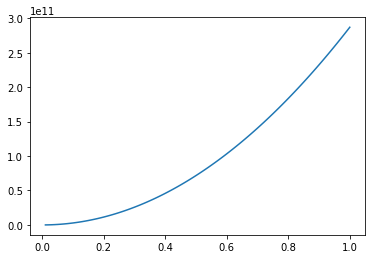

In [67]:
#Grafico la presión eléctrica en función del radio
R_array = R_cl_ini*np.linspace(0.01, 1, 100)
p_electrica_array = np.zeros(len(R_array))
p_comportamiento_array = np.zeros(len(R_array))


for i in range(len(R_array)):
    p_electrica_array[i] = p_electrica(n_e_mean(R_cl_ini), T_e(R_cl_ini), 17.9, R_array[i])
    p_comportamiento_array[i] = (R_cl_ini/R_array[i])**4

plt.plot(R_array/R_cl_ini, p_electrica_array)
# plt.plot(R_array, 3e11*p_comportamiento_array)

#Parece tener el comportamiento buscado. El problema es el orden de magnitud. Inicialmente es casi 10 órdenes de magnitud la presión p0

### Ecuación diferencial
Esta ecuación es la que gobierna la dinámica del sistema. Por simplicidad voy a considerar la ecuación (14) del papaer de Bunkin a la que le voy a sumar una presión p0 del exterior

In [7]:
from scipy.integrate import quad


#Defino el sistema de ecuaciones diferenciales. La diferencia con el anterior es el radio inicial y la carga contenida
W_array = np.array([])

def dydt(t,y):
    #Sistema de ecuaciones de primer orden para la evolución del radio en función del tiempo. Entiéndase y = (R, Rp) = (R, v_R)
    v_R = y[1]
    R = y[0]

    #Defino las ctes del sistema
    
    # R0_ = R1*n_bubston
    # q_e_ = q_e*n_bubston #NO SÉ SI ESTO ESTÁ BIEN

    #Defino los términos de la ecuación diferencial de R(t). Genéricamente coloco como inputs mp, mpp, R y v_R aunque no haya tal dependencia
    #Los términos se encuentran definidos en mi cuadernillo

    #Expreso dydt_0 = dR/dt = v_R
    dydt_0 = v_R

    #Para dydt_2 = d(v_R/dt) = d2(R)/dt2 hay 2 posibilidades
    #(1) usar la ecuación diferencial de la tesis de Gabriela
    #(2) usar la ecuación diferencial del paper de Bunkin que es una aproximación de la ecuación diferencial de Gabriela

    #(1)
    # term1 = -(3/2)*v_R**2*(1 - v_R/(3*c_L) + 2*mp(t)/(3*c_L*rho_L_i))
    # term2 = (1/rho_L_i)*(1 + v_R/c_L)*(p_B(R,T_e_, q_e_, R0_) - p_inf)
    # term3 = (mpp(t)*R/rho_L_i)*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))
    # term4 = (mp(t)/rho_L_i)*(v_R - mp(t)/(2*rho_L_i) + mp(t)*v_R/(2*c_L*rho_L_i))
    # term5 = (R/c_L*rho_L_inf)*dpBdt(R, v_R,T_e_, q_e_, R0_)
    # dydt_1 = (1/(R*(1 - v_R/c_L + mp(t)/(c_L*rho_L_i))     ))*(term1 + term2 + term3 + term4 + term5)

    #(2)
    #Calculo x_cl
    x_cl = x(T_e(R), R_cl_ini, N_e_max_1b*n_bubston)
    # print(x_cl)

    #Calculo la energía
    # def Energia_exp(R):
    # #Energía coulombiana debido a p_coulomb que es distinta a p_e
    #     def f(r):
    #         #Función a integrar para obtener la energía
    #             8*pi/2*p_electrica(n_e_mean(r), T_e(r), x_cl, r)*r**2
    #     return quad(f,0.001,R)
    # print(W_energia(R)[0]/Energia_teo(R, x_cl))
    
    dydt_1 = ((p_electrica_mean(n_e_mean(R), T_e(R), x_cl, R) - p0 -2*sigma/R -4*mu_vis*v_R/R)/(rho_L_i) - 3/2*v_R**2)/R


    # print((p_electrica(n_e_mean(R), T_e(R, R_cl_ini), x_cl, R_cl_ini) - p0))
    # print(T_e(R, R_cl_ini)/(1.602176565e-19)/(1/1e-7))

    return [dydt_0, dydt_1]

### Solución numérica

In [23]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = 0.002 #200e-5 #2.5e-6 #70 ns

v_R0 = 1747.4962431181277
y_ini = [R_cl_ini, v_R0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "LSODA")
#asumo que el problema no es stiff

# print(sol)

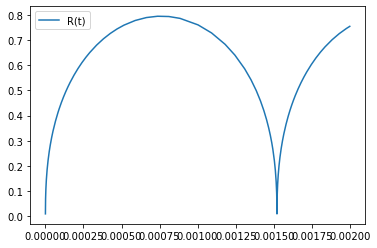

In [24]:
import matplotlib.pyplot as plt

#Grafico
plt.plot(sol.t, sol.y[0], label = "R(t)")
plt.legend()
plt.show()

# plt.plot(sol.t, sol.y[1], label = "v_R(t)")
# plt.legend()
# plt.show()

# plt.plot(sol.t, p_electrica(n_e_mean(sol.y[0]), T_e(sol.y[0], R_cl_ini), x_cl, R_cl_ini), label = "p_electrica(t)")
# plt.legend()
# plt.show()

In [25]:
#Radio máximo
print("Radio máximo: ", max(sol.y[0]), " cm")
#Tiempo al que se da el radio máximo
print("Tiempo al que se da el radio máximo: ", sol.t[np.argmax(sol.y[0])], " s")

#Radio teórico
print("Radio teórico: 0.1 cm")
#Tiempo teórico
print("Tiempo al que se da el radio máximo:  0.00009 s approx 0.0001 s ")

#Radio máximo:  0.7964667611350028  cm
#sin , rtol = rtol, atol = rtol: 0.7906010999088974  cm
#RK4 Radio máximo:  0.801649547052475  cm
#RK4 sin rtol: Radio máximo:  0.7965458768602968  cm



Radio máximo:  0.7948251773046968  cm
Tiempo al que se da el radio máximo:  0.0007372348544479772  s
Radio teórico: 0.1 cm
Tiempo al que se da el radio máximo:  0.00009 s approx 0.0001 s 


In [161]:
#Cálculo de energía

def Energia_teo(R_cl,x):
    return (N_e_max_1b*n_bubston)**2*q_e**2/(4*x*R_cl)


def Energia_exp():
    #Para cada valor de R tengo que calcular la presión y multiplicarla por el diferencial de volumen
    p_e_array = np.zeros(len(sol.t))
    for i in range(len(sol.t)):
        R = sol.y[0][i]
        x_cl = x(T_e(R), R_cl_ini, N_e_max_1b*n_bubston)
        p_e_array[i] = (p_electrica(n_e_mean(R), T_e(R), x_cl, R))

    
    #Para cada dV calculo la presión promedio y la energía como el producto de la presión con el volumen
    Energia = 0
    for j in range(len(sol.t)-1):
        dV = 4/3*pi*(sol.y[0][j+1]**3 - sol.y[0][j]**3)
        p_e_prom = (p_e_array[j+1] + p_e_array[j])/2
        Energia = Energia + dV*p_e_prom
    return Energia



In [165]:
print("Energía teórica: ", Energia_teo(R_cl_ini, 17.9), " erg")
print("Energía experimental: ", Energia_exp(), " erg")
print("Cociente de energías: ",  Energia_exp()/Energia_teo(R_cl_ini, 17.9)) 

Energía teórica:  6311.678551035401  erg
Energía experimental:  3805612.243489969  erg
Cociente de energías:  602.9477282022983


## (II) Evolución de cluster

Me olvido de las cuentas que hice antes y arranco desde cero. El objetivo es calcular la dinámica del cluster hasta que se llega a Rmax y ver si obtengo el mismo Rmax que el paper.

A diferencia del caso anterior suponemos que durante la evolución del sistema solo hay presión hidrostática (suponiendo a su vez que la burbuja tiene vacío dentro). Mientras que la presión de electrones sólo está presente a t=0 y se convierte enteramente en energía cinética. Esto está en concordancia con la fórmula de Willis

In [11]:
#Importo librerías
import numpy as np
from math import pi
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.integrate import quad #Para calcular integrales numéricamente
from scipy.optimize import fsolve #Para resolver ecuaciones algebráicas numéricamente


In [12]:
#Defino parámetros

q_e = -1.602176634e-19 #carga del electrón en [Coulomb]
q_e = q_e*(1/3.336641e-10) #en [Fr] (CGS). Conversión (C)*(Fr/3.336641e-10 C)

rho_L_i = 1101.8 #densidad del líquido en la superficie de la burbuja en [kg/m3] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela. 
rho_L_i = rho_L_i*(1/100)**3*(1000) #en [g/cm3] (CGS). Conversión (kg/m3)*(1m/100cm)^3*(1000g/1Kg)
rho_L_inf = rho_L_i #densidad del líquido en el infinito. A priori considero rho_L_inf = rho_L_i

rho_Bunkin = rho_L_inf #densidad del líquido

n_bubston = 1e8 #nro de bubston que forman un cluster

R0_1b = 1e-6 #radio inicial de un bubston en [cm]
R_cl_ini = 1e-2 #radio inicial del cluster en [cm]

N_e_max_1b = 1.4e3 #nro máximo de electrones en un bubston

T_e_ini = 2 #temperatura inicial de los electrones a R0_1b [eV]
T_e_ini = T_e_ini*(1.602176565e-19)*(1/1e-7) #en [erg] (CGS). Conversión (1ev)(1.602176565e-19J/1ev)*(1erg/1e-7 J)

p_inf = 1 #0.925 #Presión ambiente en el infinito en [atm]. Son 0.925 atm correspondientes a Bariloche. 
p_inf = p_inf*(101325)*(1/0.1) #en [baria] (CGS). Conversión: (atm)(101325 Pa/atm)(baria/ 0.1 Pa)
p0 = p_inf

### Cálculo de la energía cinética a t=0

Asumo que la energía coulombiana (expresión anterior a la 27) se convierte eneteramente en energía cinética. La expresión de la energía cinética está dada antes de 2.29 del libro The Acustic Bubble de T.G.Leighton y es $E_{cin} = 2 \pi \rho v_R^2 R^3$

In [26]:
def Vol(R):
    #Calcula el volumen de una esfera de radio R
    return 4/3*pi*R**3

def n_e_mean(R):
    #Densidad media de los electrones. En el modelo de Bunkin se asume que en un tiempo muy corto cada bubston alcanza el valor máximo de electrones. Luego, cuando se forma el cluster, se tienen n_bubston*N_emax_1bubston electrones
    return  N_e_max_1b*n_bubston/Vol(R)

def T_e(R):
    #Asumo que para la evolución del cluster sigue valiendo la aproximación de régimen autoconsistente

    #Está hecho para que a R = R_cl_ini obtenga 0.1 ev. De este modo, se está asumiendo que los electrones del cluster están a la misma temperatura que los electrones en la máxima expansión de cada bubston.
    return 0.1*(1.602176565e-19)*(1/1e-7)
    return 0.1*(1.602176565e-19)*(1/1e-7)*(R_cl_ini/R)
    # return T_e_ini*(R0_1b/R)

def x(T_e, R0, Ne):

    def ec_9(x):
        #Expresión (9) del paper de Bunkin tal que está igualada a cero
        return np.log(3*Ne*q_e**2/(T_e*R0)) + np.log(1/(1-1/x)) - x

    return fsolve(ec_9, 2)[0]

x(T_e_ini*(R0_1b/(20*R0_1b)), R_cl_ini, N_e_max_1b*n_bubston)


17.97444125009335

In [27]:
def p_coulomb(n_e_mean, x, R):
    #Presión de coulomb calculada a partir de la expresión anterior a la (17) del paper de Bunkin
    #n_e_mean es la densidad media de electrones
    #T_e es la temperatura de los electrones
    #x es un parámetros que depende de la densidad de electrones. Es un numerito
    #R_ini es el radio inicial de la burbuja. En el caso de la evolución del cluster es el radio inicial del cluster R_ini_cl
    return (2/3)*n_e_mean*(x/3)*(pi*((x-1)/x)**2*((q_e*R)**2*n_e_mean))

In [31]:
#Calculo la energía cinética a t=0
# def W_coulomb(R_cl):
#     #Calculo la energía de coulomb a partir de la expresión anterior a la (27) del Bunkin
    
#     return
#Energía coulombiana debido a p_coulomb que es distinta a p_e


# def W_coulomb(R_cl_ini):
#     x_cl_ini = x(T_e(R_cl_ini), R_cl_ini, N_e_max_1b*n_bubston)
#     def f(r):
#         #Función a integrar para obtener la energía
#         return 8*pi/2*p_coulomb(n_e_mean(R_cl_ini), x_cl_ini, r)*r**2
#     return quad(f,0.0,R_cl_ini)[0]

def W_coulomb(R_cl_ini):

    #Calculo x
    x_cl_ini = x(T_e(R_cl_ini), R_cl_ini, N_e_max_1b*n_bubston)
    #Calculo electron Debye Radius
    a_e = R_cl_ini/x_cl_ini

    #Defino el campo eléctrico a partir de la expresión (16)
    def E(r):
        return 2*T_e(R_cl_ini)*a_e/(3*q_e*r**2)*(np.sinh(r/a_e) - (r/a_e)*np.cosh(r/a_e))
    
    #Defino la función a integrar para calcular W_coulomb
    def f(r):
        return r**2*E(r)**2

    #Integro
    return 1/2*quad(f,0,R_cl_ini)[0]



print(W_coulomb(R_cl_ini))

# W_coulomb = 6.3e3 # [ergios] (CGS)

#Calculo la volocidad a t=0 a partir de la igualdad E_cin = W_coulomb
v_R0 = np.sqrt(W_coulomb(R_cl_ini)/(2*pi*rho_Bunkin*R_cl_ini**3))
print(v_R0)


6263.723883853653
30079.80276947704


### Ecuación diferencial

In [32]:
#Defino la ecuación diferencial

def dydt(t,y):
    #Sistema de ecuaciones de primer orden para la evolución del radio en función del tiempo. Entiéndase y = (R, Rp) = (R, v_R)
    v_R = y[1]
    R = y[0]

    #Expreso dydt_0 = dR/dt = v_R
    dydt_0 = v_R

    #Para dydt_2 = d(v_R/dt) = d2(R)/dt2 hay 2 posibilidades
    #(1) usar la ecuación diferencial de la tesis de Gabriela
    #(2) usar la ecuación diferencial del paper de Bunkin que es una aproximación de la ecuación diferencial de Gabriela

    dydt_1 = ((-p0)/(rho_Bunkin) - 3/2*v_R**2)/R

    return [dydt_0, dydt_1]

### Solución numérica

In [37]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = 0.002 #200e-5 #2.5e-6 #70 ns

y_ini = [R_cl_ini, v_R0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol)
#asumo que el problema no es stiff


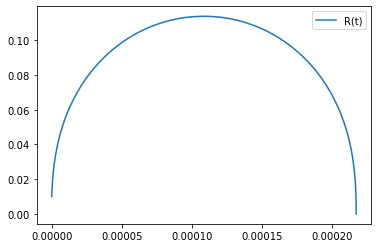

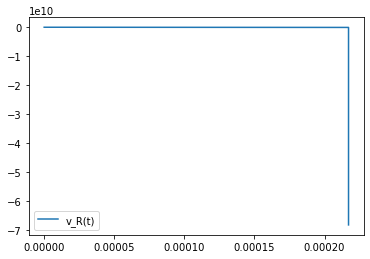

In [38]:
#Grafico
plt.plot(sol.t, sol.y[0], label = "R(t)")
plt.legend()
plt.show()

plt.plot(sol.t, sol.y[1], label = "v_R(t)")
plt.legend()
plt.show()

# plt.plot(sol.t, p_electrica(n_e_mean(sol.y[0]), T_e(sol.y[0], R_cl_ini), x_cl, R_cl_ini), label = "p_electrica(t)")
# plt.legend()
# plt.show()

In [39]:
#Radio máximo
print("Radio máximo: ", max(sol.y[0]), " cm")
#Tiempo al que se da el radio máximo
print("Tiempo al que se da el radio máximo: ", sol.t[np.argmax(sol.y[0])], " s")

#Radio teórico
print("Radio teórico: 0.1 cm")
#Tiempo teórico
print("Tiempo al que se da el radio máximo:  0.00009 s approx 0.0001 s ")

#Radio máximo:  0.7964667611350028  cm
#sin , rtol = rtol, atol = rtol: 0.7906010999088974  cm
#RK4 Radio máximo:  0.801649547052475  cm
#RK4 sin rtol: Radio máximo:  0.7965458768602968  cm


Radio máximo:  0.11387350277376078  cm
Tiempo al que se da el radio máximo:  0.00010740911096376285  s
Radio teórico: 0.1 cm
Tiempo al que se da el radio máximo:  0.00009 s approx 0.0001 s 


#### Comentarios
* Usando W_coulomb = 6.3e3 # [ergios] (CGS) obtengo R_max = 0.11 cm a t = 0.00011 s.
* Haciendo la cuenta para obtener W_coulomb = 6.263e [ergios] (CGS) obtengo lo mismo.


OBTENGO EL RESULTADO DEL BUNKIN!!